In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow import keras

2023-01-05 11:49:05.372878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
image_dir = './BrainTumorsData/brain_tumor_dataset/'

image_size = (256, 256)
batch_size = 128
class_names = ['yes', 'no']
os.listdir(image_dir)

train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size)



Found 253 files belonging to 3 classes.
Using 203 files for training.
Using 50 files for validation.


2023-01-05 11:49:10.939254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


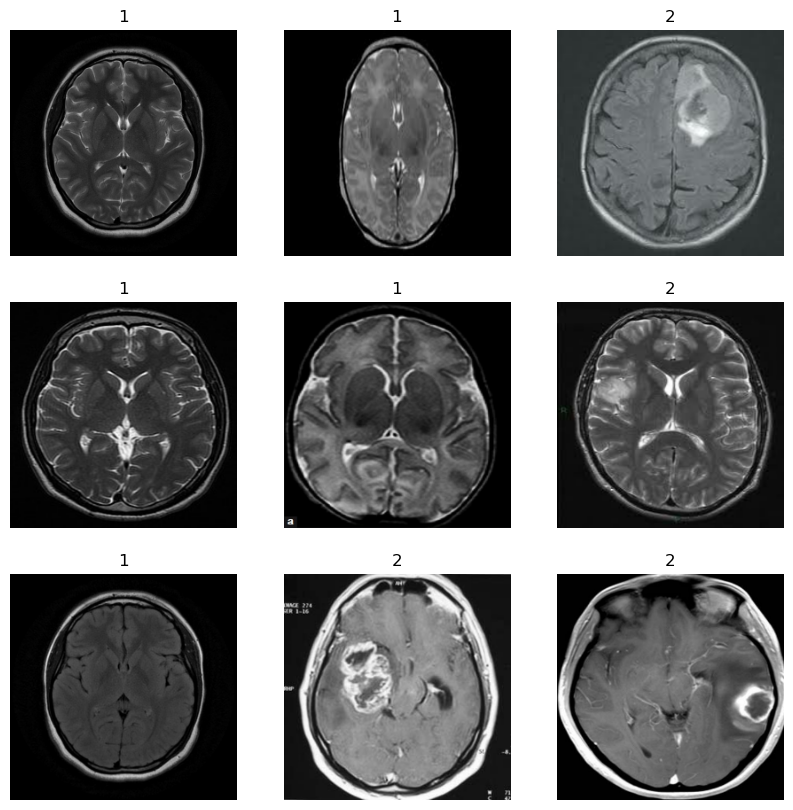

In [3]:
# Display Images with their Label
# 1 = No tumor, 2 = tumor

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

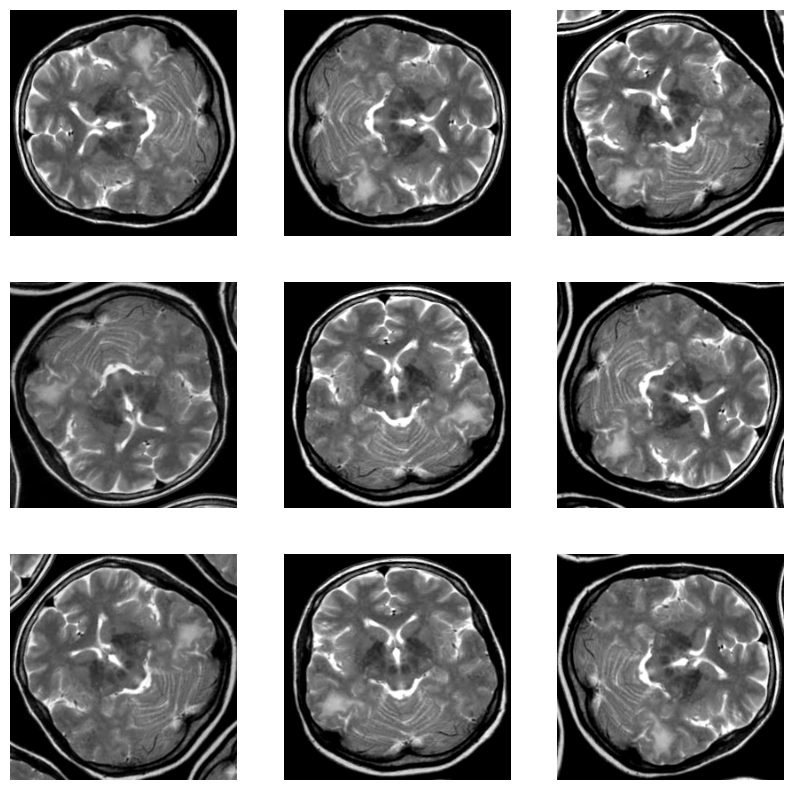

In [4]:
# Increasing the amount of data by rotating images in order to generate more for the model to be trained by

factor = [0, 0.5]

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation(0.25),
        tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),
        tf.keras.layers.RandomContrast(factor)
    ])

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [5]:
# Create augmented training data
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
augmented_train_ds

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


<MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE)

# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

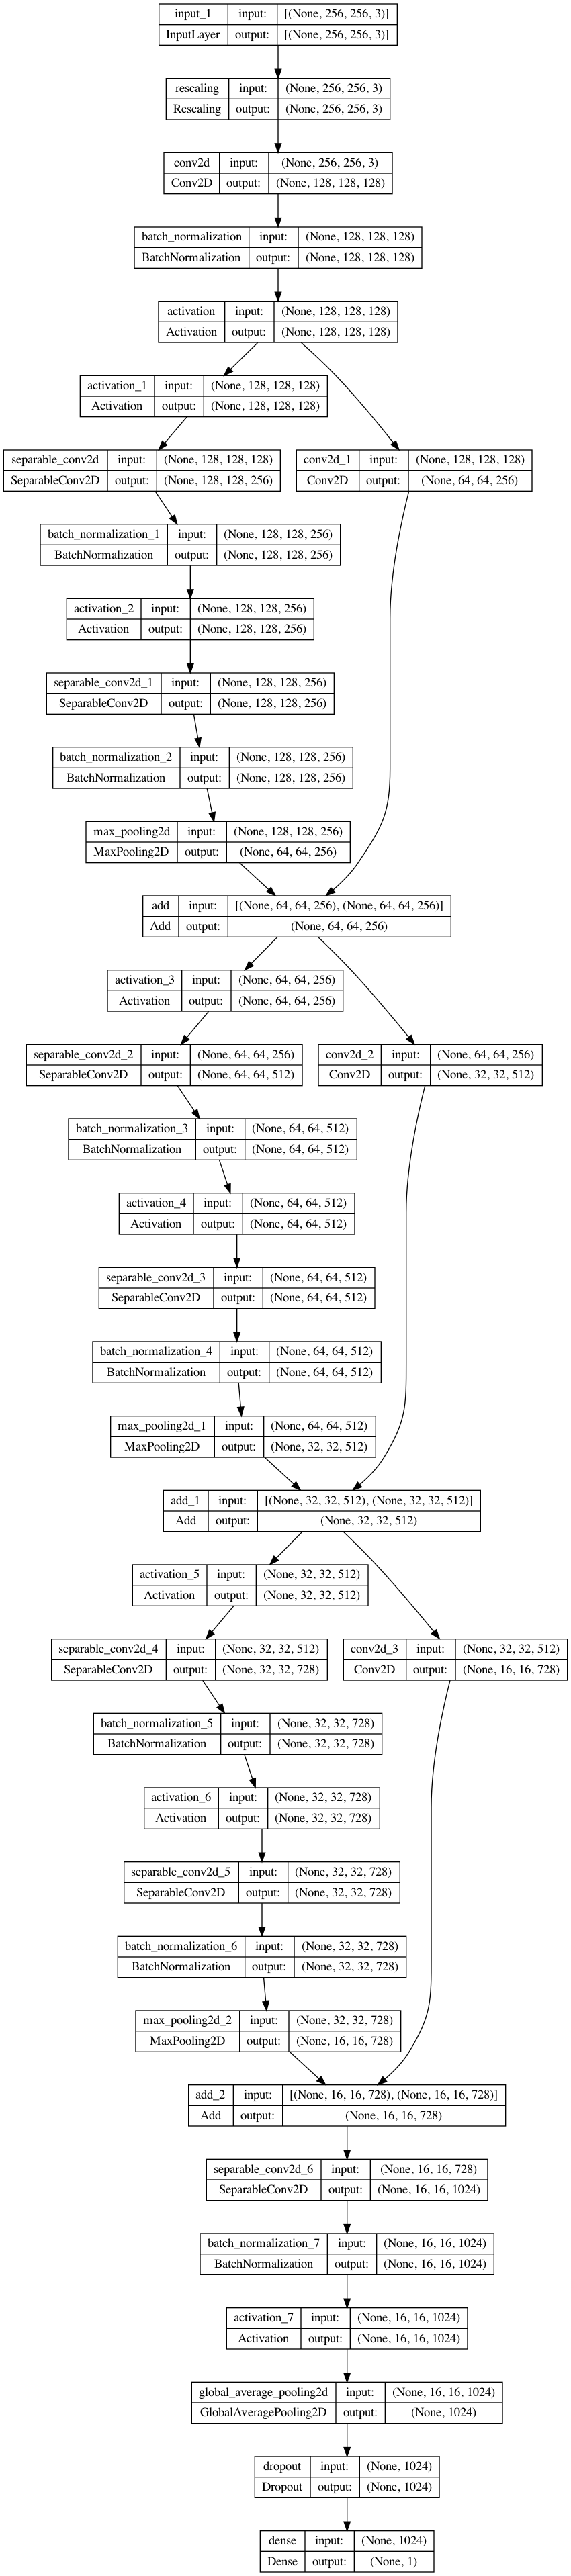

In [7]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
tf.keras.utils.plot_model(model, show_shapes=True)

In [8]:
epochs = 35

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=None,
    validation_data=val_ds,
)

Epoch 1/35
2/2 [==============================] - 125s 42s/step - loss: 0.2567 - accuracy: 0.2365 - val_loss: 0.6395 - val_accuracy: 0.4000
Epoch 2/35
2/2 [==============================] - 122s 38s/step - loss: -1.3954 - accuracy: 0.3547 - val_loss: 0.5815 - val_accuracy: 0.4000
Epoch 3/35
2/2 [==============================] - 167s 44s/step - loss: -2.4707 - accuracy: 0.3103 - val_loss: 0.5164 - val_accuracy: 0.4000
Epoch 4/35
2/2 [==============================] - 139s 44s/step - loss: -3.4701 - accuracy: 0.3300 - val_loss: 0.4480 - val_accuracy: 0.4000
Epoch 5/35
2/2 [==============================] - 172s 41s/step - loss: -4.3445 - accuracy: 0.3596 - val_loss: 0.3722 - val_accuracy: 0.4000
Epoch 6/35
2/2 [==============================] - 139s 36s/step - loss: -5.1849 - accuracy: 0.3695 - val_loss: 0.2916 - val_accuracy: 0.4000
Epoch 7/35
2/2 [==============================] - 169s 46s/step - loss: -6.0952 - accuracy: 0.3695 - val_loss: 0.2046 - val_accuracy: 0.4000
Epoch 8/35
2/2

In [9]:
img = keras.preprocessing.image.load_img("./BrainTumorsData/no/2 no.jpeg", target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
predictions = model.predict(img_array)
score = float(predictions[0])
score
# print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

1/1 [==============================] - 1s 1s/step


0.7592134475708008

In [10]:
img = keras.preprocessing.image.load_img("./BrainTumorsData/yes/Y101.jpg", target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
predictions = model.predict(img_array)
score = float(predictions[0])
score
# print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

1/1 [==============================] - 0s 114ms/step


0.756767988204956